In [9]:
from IPython.display import display, clear_output
import numpy as np
import torch
import sys
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split, dataset
import pandas as pd
import random

In [10]:
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

In [11]:
from lib.util import MHPI, calculate_rmse, calculate_r2, count_parameters, calculate_metrics
from lib.utiltools import loss_live_plot, GaussianRandomFieldGenerator, generate_batch_parameters, AutomaticWeightedLoss, plot_losses_from_excel
from lib.DerivativeComputer import batchJacobian_AD

In [12]:
from models.Polynomial_Neural_Operator import PNO1DTime
from models.Convolutional_Neural_Operators2d import CNO1DTime
from models.DeepONet2d import DNO1DTime
from models.FNO_2d import FNO2d
from models.WNO_2d import WNO2d
from models.MultiWaveletConv_2d import MWNO2d

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../"


In [14]:
Operator = 'FNO'    # PMO, CNO, DeepONet
enable_ig_loss = False
label = 'SC_' + Operator if enable_ig_loss else Operator

In [15]:
state_size, parameter_size = 1, 42

In [16]:
train_sample = 100
eval_sample = 150
test_sample = 100
n_zone = 20
# Set Mode based on IG loss
Mode = Operator + f"_Data_{'IG_' if enable_ig_loss else ''}zoned_2_{n_zone}_{train_sample}"

# Load dataset
filename = f'datasets/train_dataset_zones_2_{n_zone}.pt'
dataset = torch.load(PATH + filename, weights_only=False)

# Set seeds
random.seed(42)
torch.manual_seed(42)

# Check dataset size
total_samples = train_sample + eval_sample + test_sample
if len(dataset) < total_samples:
    raise ValueError("Dataset too small for desired splits")

# Create splits
indices = torch.randperm(len(dataset))
train_indices = indices[:train_sample]
eval_indices = indices[train_sample:train_sample + eval_sample]
test_indices = indices[train_sample + eval_sample:total_samples]
rest_indices = indices[total_samples:]  # All remaining data

# Create data loaders
train_data = torch.utils.data.Subset(dataset, train_indices)
eval_data = torch.utils.data.Subset(dataset, eval_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)
rest_data = torch.utils.data.Subset(dataset, rest_indices)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
rest_loader = DataLoader(rest_data, batch_size=1, shuffle=False)

# Print dataset splits information
print(f"Dataset splits:")
print(f"Total dataset size: {len(dataset)}")
print(f"Training samples: {len(train_data)}")
print(f"Evaluation samples: {len(eval_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Rest samples: {len(rest_data)}")

Dataset splits:
Total dataset size: 1000
Training samples: 100
Evaluation samples: 150
Test samples: 100
Rest samples: 650


In [17]:
dataset.dataset.tensors[0].shape

torch.Size([1300, 42])

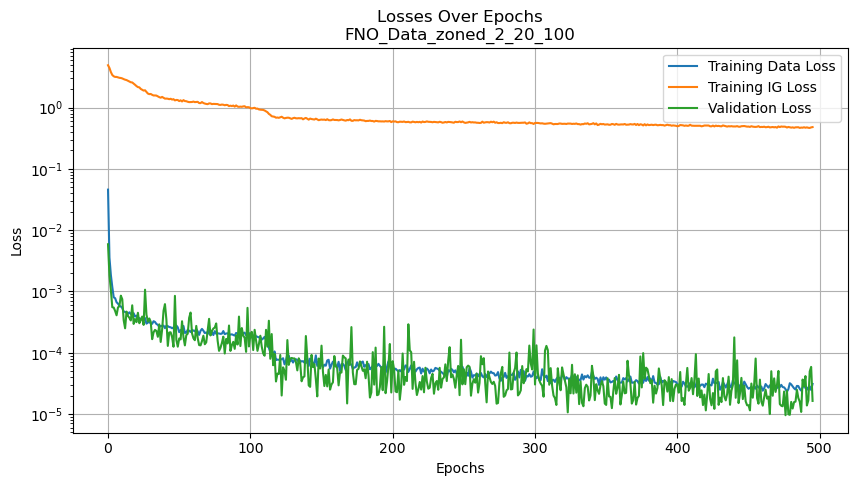

In [25]:
plot_losses_from_excel(PATH + 'loss/' + f'losses_data_{Mode}.xlsx', lable=Mode)

In [19]:
L = 1.0
dx = 0.025
nx = int(L / dx)
x = torch.linspace(0, L, nx, device=device)

In [20]:
t0 = 0.0
t_end = torch.pi
steps_solve = 210
step_save = 30
T_in = 5
T_out = step_save - T_in

In [21]:
checkpoint = torch.load(PATH + 'saved_models/' + Mode + '_saved_model.pth', weights_only=False)

In [22]:
if Operator == 'CNO':
    width = checkpoint['width']
    depth = checkpoint['depth']
    kernel_size = checkpoint['kernel_size']
    model = CNO1DTime(nx, T_in, T_out, state_size, parameter_size, width, depth, kernel_size).to(device)
elif Operator == 'PNO':
    poly_degree = checkpoint['poly_degree']
    width = checkpoint['width']
    depth = checkpoint['depth']
    model = PNO1DTime(nx, T_in, T_out, state_size, parameter_size, poly_degree, width, depth).to(device)
elif Operator =='DeepONet':
    branch_layers = checkpoint['branch_layers']
    trunk_layers = checkpoint['trunk_layers']
    model = DNO1DTime(nx, T_in, T_out, state_size, parameter_size, branch_layers, trunk_layers).to(device)
elif Operator =='FNO':
    modes1 = checkpoint['modes1']
    modes2 = checkpoint['modes2']
    width = checkpoint['width']
    model = FNO2d(modes1, modes2,  width, T_in, T_out, parameter_size=parameter_size, state_size=1).to(device)
elif Operator =='WNO':
    levels = checkpoint['levels']
    size = checkpoint['size']
    width = checkpoint['width']
    model = WNO2d(levels=levels, size=[nx, nx], width=width, T_in=T_in, T_out=T_out, state_size=1, parameter_size=parameter_size).to(device)    
elif Operator =='MWNO':
    levels = checkpoint['levels']
    size = checkpoint['size']
    width = checkpoint['width']
    model = MWNO2d(levels=levels, size=[nx, nx], width=width, T_in=T_in, T_out=T_out, state_size=1, parameter_size=parameter_size).to(device)

In [23]:
model.load_state_dict(checkpoint['model_state_dict'])
print(f'{label}: {count_parameters(model)}')


FNO: 107897


In [24]:
U_pred_list, du_dp_list, batch_u_out_list, du_dparam_true_list = [], [], [], []
model.eval()  # Set the model to evaluation mode.

for batch_data in test_loader:
    batch_data_1 = [item.to(device) for item in batch_data]
    batch_parameters, batch_u, du_dparam_true = batch_data_1
    batch_u_in, batch_u_out = batch_u[..., :T_in, :], batch_u[..., T_in:, :]
    
    batch_size_ = batch_parameters.shape[0]
    batch_parameters.requires_grad_(True)        
    
    U_in = batch_u_in
    if Operator =='FNO' or Operator == 'WNO' or Operator == 'MWNO':
        t_tensor_ = torch.linspace(t0, t_end, step_save)[T_in:].unsqueeze(0).repeat(batch_size_, 1).to(device)
        x_tensor_ = torch.linspace(0, L, nx).unsqueeze(0).repeat(batch_size_, 1).to(device)
        U_pred = model(U_in, x_tensor_, t_tensor_, batch_parameters)
    else:
        U_pred = model(U_in, batch_parameters)
    du_dp = torch.zeros(batch_size_, nx, T_out, model.parameter_size, model.state_size).to(device)
    
    for i in range(model.state_size):
        state_tensor = U_pred[..., i]
        Jacobian = batchJacobian_AD(state_tensor.reshape(batch_size_, nx * T_out), batch_parameters, graphed=False, batchx=True)
        du_dp[..., i] = Jacobian.reshape(batch_size_, nx, T_out, model.parameter_size)
    
    torch.cuda.empty_cache()
    U_pred_list.append(U_pred.detach())    
    du_dp_list.append(du_dp[:, :, :, :, :].detach())
    batch_u_out_list.append(batch_u_out.detach())
    du_dparam_true_list.append(du_dparam_true)

U_pred = torch.cat(U_pred_list, dim=0)
du_dp = torch.cat(du_dp_list, dim=0)
batch_u_out = torch.cat(batch_u_out_list, dim=0)
du_dparam_true = torch.cat(du_dparam_true_list, dim=0)

In [103]:
RMSE_Grads = torch.zeros(parameter_size)
R2_Grads = torch.zeros(parameter_size)  
L2_Grads = torch.zeros(parameter_size)
RelL2_Grads = torch.zeros(parameter_size) 
MaxL1_Grads = torch.zeros(parameter_size)

for i in range(parameter_size):
   predictions = du_dp[:, :, :, i, 0].cpu().detach()
   true_values = du_dparam_true[:, :, T_in:, i, 0].cpu().detach()
   RMSE_Grads[i], R2_Grads[i], L2_Grads[i], RelL2_Grads[i], MaxL1_Grads[i] = calculate_metrics(predictions, true_values)

RMSE_U, R2_U, L2_U, RelL2_U, MaxL1_U = calculate_metrics(U_pred, batch_u_out)

# Calculate mean metrics for Jacobian
mean_R2 = torch.mean(R2_Grads)
mean_RMSE = torch.mean(RMSE_Grads)
mean_L2 = torch.mean(L2_Grads)
mean_RelL2 = torch.mean(RelL2_Grads)
mean_MaxL1 = torch.mean(MaxL1_Grads)

print(f"\n{'='*50}")
print(f"Mode: {Mode}")
print(f"{'='*50}")

print("\nState Value Metrics:")
print(f"{'='*20}")
print(f"R²      : {R2_U:.5f}")
print(f"RMSE    : {RMSE_U:.5f}")
print(f"L2      : {L2_U:.5f}")
print(f"Rel L2  : {RelL2_U:.5f}")
print(f"Max L1  : {MaxL1_U:.5f}")

print("\nMean Jacobian Metrics:")
print(f"{'='*20}")
print(f"R²      : {mean_R2:.5f}")
print(f"RMSE    : {mean_RMSE:.5f}")
print(f"L2      : {mean_L2:.5f}")
print(f"Rel L2  : {mean_RelL2:.5f}")
print(f"Max L1  : {mean_MaxL1:.5f}")

print("\nJacobian Metrics by Parameter:")
print(f"{'='*20}")
for i in range(parameter_size):
   print(f"\nParameter {i+1}:")
   print(f"R²      : {R2_Grads[i]:.5f}")
   print(f"RMSE    : {RMSE_Grads[i]:.5f}")
   print(f"L2      : {L2_Grads[i]:.5f}")
   print(f"Rel L2  : {RelL2_Grads[i]:.5f}")
   print(f"Max L1  : {MaxL1_Grads[i]:.5f}")
print(f"\n{'='*50}\n")


Mode: FNO_Data_zoned_2_20_100

State Value Metrics:
R²      : 0.98355
RMSE    : 0.02588
L2      : 8.18286
Rel L2  : 0.01873
Max L1  : 0.12286

Mean Jacobian Metrics:
R²      : -0.29365
RMSE    : 0.07325
L2      : 23.16230
Rel L2  : 0.83926
Max L1  : 0.33532

Jacobian Metrics by Parameter:

Parameter 1:
R²      : 0.72096
RMSE    : 0.04642
L2      : 14.67879
Rel L2  : 0.40191
Max L1  : 0.32908

Parameter 2:
R²      : 0.77502
RMSE    : 0.03371
L2      : 10.66035
Rel L2  : 0.36946
Max L1  : 0.23515

Parameter 3:
R²      : 0.70696
RMSE    : 0.03070
L2      : 9.70974
Rel L2  : 0.44510
Max L1  : 0.26971

Parameter 4:
R²      : 0.65345
RMSE    : 0.02818
L2      : 8.91242
Rel L2  : 0.53616
Max L1  : 0.22920

Parameter 5:
R²      : 0.63102
RMSE    : 0.02545
L2      : 8.04806
Rel L2  : 0.60399
Max L1  : 0.19293

Parameter 6:
R²      : 0.54127
RMSE    : 0.02703
L2      : 8.54890
Rel L2  : 0.65214
Max L1  : 0.17057

Parameter 7:
R²      : 0.46521
RMSE    : 0.02976
L2      : 9.40969
Rel L2  : 0.626

In [ ]:
# ==================================================
# Mode: SC-FNO number N=100
# ==================================================

# State Value Metrics:
# ====================
# R²      : 0.99803
# RMSE    : 0.00908
# L2      : 2.87063
# Rel L2  : 0.00663
# Max L1  : 0.05400

# Mean Jacobian Metrics:
# ====================
# R²      : 0.96143
# RMSE    : 0.01014
# L2      : 3.20573
# Rel L2  : 0.15567
# Max L1  : 0.09881



# ==================================================
# Mode: FNO number N=100
# ==================================================

# State Value Metrics:
# ====================
# R²      : 0.98355
# RMSE    : 0.02588
# L2      : 8.18286
# Rel L2  : 0.01873
# Max L1  : 0.12286

# Mean Jacobian Metrics:
# ====================
# R²      : -0.29365
# RMSE    : 0.07325
# L2      : 23.16230
# Rel L2  : 0.83926
# Max L1  : 0.33532


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
width = 0.55
# Data for the plots
metrics = ['R²', 'RMSE', 'L2', 'Rel L2', 'Max L1']
fno_400 = [0.99622, 0.01259, 3.98082, 0.00920, 0.10226]
ig_400 = [0.99803, 0.00908, 2.87063, 0.00663, 0.05400]
fno_100 = [0.98355, 0.02588, 8.18286, 0.01873, 0.12286]
ig_100 = [0.99743, 0.01024, 3.23740, 0.00741, 0.05732]

# Function to create individual plots for each metric
def plot_metric(index, metric):
    fig, ax = plt.subplots()
    # Setup positions for each group of bars on the x-axis
    positions = np.array([0, 1, 2, 3])  # Four positions for four models
    
    # Draw the bars
    ax.bar(positions[0], fno_400[index], width, label='FNO 400')
    ax.bar(positions[1], ig_400[index], width, label='SC-FNO 400')
    ax.bar(positions[2], fno_100[index], width, label='FNO 100')
    ax.bar(positions[3], ig_100[index], width, label='SC-FNO 100')
    
    ax.set_ylabel('Values')
    ax.set_title(f'{metric}')
    ax.set_xticks(positions)
    ax.set_xticklabels(['FNO 400', 'SC-FNO 400', 'FNO 100', 'SC-FNO 100'])
    
    # Adding text labels above bars
    heights = [fno_400[index], ig_400[index], fno_100[index], ig_100[index]]
    for pos, height in zip(positions, heights):
        ax.annotate(f'{height:.4f}',
                    xy=(pos, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

# Plot each metric separately
for i, metric in enumerate(metrics):
    plot_metric(i, metric)


In [ ]:
# Mode:SC_FNO
    # R2 state value :0.99784
    # R2 du/dp1: 0.99438
    # R2 du/dp2: 0.99214
    # R2 du/dp3: 0.99064
    # R2 du/dp4: 0.98440
    # R2 du/dp5: 0.98535
    # R2 du/dp6: 0.98422
    # R2 du/dp7: 0.98877
    # R2 du/dp8: 0.98884
    # R2 du/dp9: 0.98762
    # R2 du/dp10: 0.98805
    # R2 du/dp11: 0.99099
    # R2 du/dp12: 0.98607
    # R2 du/dp13: 0.98504
    # R2 du/dp14: 0.97483
    # R2 du/dp15: 0.98306
    # R2 du/dp16: 0.97810
    # R2 du/dp17: 0.97652
    # R2 du/dp18: 0.98222
    # R2 du/dp19: 0.98977
    # R2 du/dp20: 0.99399
    # R2 du/dp21: 0.99209
    # R2 du/dp22: 0.99763
    # R2 du/dp23: 0.99770

# Mode:FNO
    # R2 state value :0.99652
    # R2 du/dp1: 0.82723
    # R2 du/dp2: 0.93732
    # R2 du/dp3: 0.94056
    # R2 du/dp4: 0.86718
    # R2 du/dp5: 0.74658
    # R2 du/dp6: 0.62867
    # R2 du/dp7: 0.56529
    # R2 du/dp8: 0.55144
    # R2 du/dp9: 0.55345
    # R2 du/dp10: 0.61786
    # R2 du/dp11: 0.75975
    # R2 du/dp12: 0.82485
    # R2 du/dp13: 0.89575
    # R2 du/dp14: 0.89382
    # R2 du/dp15: 0.85211
    # R2 du/dp16: 0.78980
    # R2 du/dp17: 0.74634
    # R2 du/dp18: 0.72259
    # R2 du/dp19: 0.73129
    # R2 du/dp20: 0.75165
    # R2 du/dp21: 0.79082
    # R2 du/dp22: 0.96211
    # R2 du/dp23: 0.93573


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import numpy as np

In [ ]:
def animate_solution_comparison(data_true, data_pred):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.linspace(0, 1, data_true.shape[0])
    line_true, = ax.plot(x, data_true[:, 0], label='True', marker='o')
    line_pred, = ax.plot(x, data_pred[:, 0], label=f'{label}')
    
    ax.set_ylim(min(data_true.min(), data_pred.min()), max(data_true.max(), data_pred.max()))
    ax.set_xlabel('x', fontsize = 16)
    ax.set_ylabel('u(x,t)', fontsize = 16)
    ax.set_title('True vs Predicted Solution Evolution Over Time')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.legend(fontsize=14)
    def update(frame):
        line_true.set_ydata(data_true[:, frame])
        line_pred.set_ydata(data_pred[:, frame])
        return line_true, line_pred
    anim = FuncAnimation(fig, update, frames=data_true.shape[1], interval=400, blit=True)
    plt.close(fig)
    return anim

Assuming you have already loaded your data and performed predictions

In [ ]:
sample_idx = 6  # You can change this to any index you want to visualize
data_true = batch_u_out[sample_idx, :, :, 0].cpu().detach().numpy()
data_pred = U_pred[sample_idx, :, :, 0].cpu().detach().numpy()
anim = animate_solution_comparison(data_true, data_pred)
anim.save(f'reaction_diffusion_advection_comparison_{sample_idx}_{label}.gif', writer='pillow')